# Example using Neural Networks to solve DPPs

## Cooper Ejarque (2003)


The firm's value function is given by:
\begin{align}
V(A, K) = \max_{K'} \left\{ \pi(K, A) - (K' - (1-\delta)K) - C(K',K) + \beta E_{A'|A} \left[ V(A', K') \right] \right\}
\end{align}
where 
\begin{align}
\pi &= A K ^ \alpha \\
\log(A') &= \rho \log(A) + \sigma \epsilon\\
\epsilon_t &\sim N(0, 1).
\end{align}
Investment depends on a random variable, $z_t$, which (in logs) follows an AR(1) process with persistence $\rho$ and with a standard deviation of innovations given by $\sigma$.

The **state** of the economy is 2-dimensional and given by $\mathbf{X} = [A, K]$ as before the **policy** is 1-dimensional and dented with $f(\mathbf{X}) = K'$.

We are interested in approximating the policy $f(\cdot)$ with a neural network $\mathcal{N}(\cdot)$, such that $\mathcal{N}(\mathbf{X}) = \mathcal{N}([A, K]) \approx f(\mathbf{X}) = K $.  

Taking the first order condition with respect to $K'$, we obtain and applying the [Envelope theorem](https://en.wikipedia.org/wiki/Envelope_theorem), we obtain
\begin{align}
C_{K'}((K',K)) + 1 - \beta E_{A'|A} \left[ \pi_{K}(A', K')  + (1-\delta) - C_{K'}(K'',K')\right] &= 0\\
\end{align}

Our goal is to find a policy function $f(\cdot)$, such that this equation is fulfilled for $K'= f(\mathbf{X})$ and $K''= f(\mathbf{X'})$.  

We will encode the FOC error as the **loss function** to train the neural network.  
I.e. we will train the neural network $\mathcal{N}(\cdot)$ such that the implied policy fulfills the equation above for given states $\mathbf{X}$.  

In [1]:
# Import necessary libraries
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
import ar1_approx as ar1
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.size"] = 15

%matplotlib inline

## Define the parameters

We define the economic parameters, which are constant thoughout and will be globals in this notebook.

In [2]:
beta = 0.95
delta = 0.15
gamma = 0.1647
alpha_k = 0.297  # 0.699
sigma_tfp = 0.213 #0.857 # std. dev. for tfp process innvoations
rho_tfp = 0.6 #0.111 # persistence of tfp process

## Discretize the random shocks to the AR(1) process for A

Rather than create approximating the AR(1) with a first-order Markov chain as in the value function approach, we will use Gaussian quadrature to approximate the expectation operator.


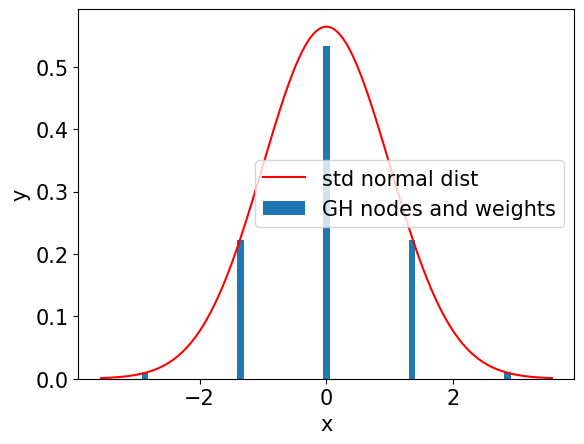

sum(w_int) =  1.0000001
Maximum steady state capital stock is:  10
Alternative maximum steady state capital stock is:  4.0049605
Integration nodes adjusted for tfp process std. dev.:  [0.5441477 0.7492007 1.        1.3347559 1.8377365]


In [27]:
n_int = 5 # integration nodes
x_int_norm, w_int = np.polynomial.hermite.hermgauss(n_int) # obtain standard GH nodes and weights
w_int = w_int / np.sqrt(np.pi) # divide the weights by sqrt(pi)
x_int_norm = x_int_norm * np.sqrt(2) # multiply weights with 2**0.5

#convert to tensorflow
x_int_norm = tf.constant(x_int_norm, dtype = tf.float32)
w_int = tf.constant(w_int, dtype = tf.float32)

# for plotting the normal distribution
x_plot_norm = np.linspace(np.min(x_int_norm) - 0.7, np.max(x_int_norm) + 0.7, 200)
y_plot_norm = np.exp(- 0.5 * x_plot_norm ** 2) / np.sqrt(np.pi)

plt.bar(x_int_norm, w_int, width = 0.1, label = "GH nodes and weights")
plt.plot(x_plot_norm, y_plot_norm, color = "r", label = "std normal dist")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# we should make sure the weights some to 1
print("sum(w_int) = ", np.sum(w_int))

# Find maximum steady state capital stock
x_int = x_int_norm * sigma_tfp # adjust the integration nodes
A_bar = np.exp(x_int[-1])
K_bar = (A_bar / delta) ** (1 / (1 - alpha_k))
K_bar_alt = (
    (1 + gamma * delta - beta + beta * delta - beta * gamma * delta + (gamma / 2) * beta * delta ** 2) /
    (beta * alpha_k * A_bar)) ** (1 / (alpha_k - 1))
K_bar = 10
print("Maximum steady state capital stock is: ", K_bar)
print("Alternative maximum steady state capital stock is: ", K_bar_alt)
print("Integration nodes adjusted for tfp process std. dev.: ", np.exp(x_int))

# Define functions for calculating profits and adjustment costs

We define functions for calculating profits and adjustment costs, as well as their derivatives with respect to capital stock.

In [4]:
@tf.function
def c_prime1(k_1, k_0, gamma, delta):
    """
    Compute derivative of adjustment cost function w.r.t first argument
    """
    c1 = gamma * (k_1 / k_0 - (1 - delta))

    return c1


@tf.function
def c_prime2(k_1, k_0, gamma, delta):
    """
    Compute derivative of adjustment cost function w.r.t. second argument
    """
    c2 = (gamma / 2) * ((1 - delta) ** 2 - (k_1 / k_0) ** 2)

    return c2


@tf.function
def mpk(z, k, alpha_k):
    """
    Compute marginal product of capital.
    """
    mpk = alpha_k * z * (k ** (alpha_k - 1))

    return mpk

## Define the loss function

#### Deep neural network 

In this section, we define the architecture of the deep neural net.  
Our goal is for the neural network to approximate the choice of capital next period, $K_{t+1}$, such that $K_{t+1} \approx \mathcal{N}\left(X_t \right)$.  

The neural network input is hence a now 2-dimensional state $\mathbf{X}_t = [A_t, K_t]$ and the output is the 1-dimensional choice of capital next period, $K_{t+1}$.


##### Hyper parameters

* Hyper parameters define the architecture of the deep neural net. 

* Note that the purpose of this notebook is in the demonstration of the deep neural net. Detail analyses of the choice of hyper parameters are omitted and we use a densely connected feed forward neural network with two hidden layers as in [Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575). 

Since we are approximating the capital stock, we want our architecture to ensure that $K_{t+1} \in (\epsilon, \bar{K})$, where $\bar{K} = $(\frac{\bar{A}}{\delta})^\frac{1}{1-\alpha}$. 

We can do this by using a [sigmoid activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6) in the output layer and transforming it by multiplying by $\bar{K}$ and adding $\epsilon$. This is in the spirit of encoding prior knowledge based on economics directly into the neural network architecture (relatedly, [Kahou et al (2021)](https://www.nber.org/papers/w28981) and [Han et al. (2022)](https://arxiv.org/abs/2112.14377) show how symmetry can be encoded into the neural-network architecture and [Azinovic and Žemlička (2023)](https://arxiv.org/abs/2303.14802) introduce market clearing neural network architectures.).  We assume the following structure of layers and activation functions: 
    * Layer 1: the input layer, 2 neurons corresponding to the tfp value $A_t$ and the capital stock $K_t$  
    * Layer 2: the first hidden layer, 50 neurons and is activated by Relu  
    * Layer 3: the second hidden layer, 50 neurons and is activated by Relu  
    * Layer 4: the output layer, 1 neurons corresponding to the capital stock $K_t+1$, We use a [sigmoid activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6), and then transform this output, ensuring that $K_{t+1} \in (\epsilon, \bar{K})$.

In [5]:
# Layer setting
num_input = 2
num_hidden1 = 100
num_hidden2 = 100
num_output = 1
layers_dim = [num_input, num_hidden1, num_hidden2, num_output]
print("Dimensions of each layer are {}".format(layers_dim))

Dimensions of each layer are [2, 100, 100, 1]


##### We define the neural network
We use [Keras](https://www.tensorflow.org/guide/keras) to define the neural network.

We'll create a custom layer to handle the output transformation, transforming from the sigmoid output ($\in (0,1)$) to the desired range for capital stock ($(\epsilon, \bar{K})$).

In [6]:
class BoundedOutput(keras.layers.Layer):
    def __init__(self, lower_bound, upper_bound, **kwargs):
        super().__init__(**kwargs)
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def call(self, inputs):
        # inputs are sigmoid outputs in (0, 1)
        return self.lower_bound + inputs * (self.upper_bound - self.lower_bound)

    def get_config(self):
        config = super().get_config()
        config.update({
            "lower_bound": self.lower_bound,
            "upper_bound": self.upper_bound
        })
        return config

# Now use custom layer in the neural network
nn = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', input_shape=(num_input,)),
    keras.layers.Dense(num_hidden2, activation='relu'),
    keras.layers.Dense(num_output, activation='sigmoid'),
    BoundedOutput(0.001, K_bar)
])

/Users/jason.debacker/anaconda3/envs/econ833-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
print(nn.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bounded_output (BoundedOutput)  │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,501 (41.02 KB)

 Trainable params: 10,501 (41.02 KB)

 Non-trainable params: 0 (0.00 B)

None


##### The batch dimension
Since neural networks are highly parallelizable, we typically do not want to evaluate the neural network for only a single state $\mathbf{X} \in \mathbb{R}^2$, but for a matrix of $N_{data}$ different states $X \in \mathbb{R}^{N_{data}\times 2}$. The output of the neural network is then a vector $\mathbf{s}\in \mathbb{R}^{N_{data}\times 1}$.  
The convention in deep learning is to have the different data samples on the 0-axis.

In [28]:
# test it
X_test = np.array([[1., 1.], [0.5, 10.]])

print("X_test = ", X_test)
print("nn prediction = ", nn(X_test))

X_test =  [[ 1.   1. ]
 [ 0.5 10. ]]
nn prediction =  tf.Tensor(
[[1.3934938]
 [1.3377305]], shape=(2, 1), dtype=float32)


#### Implementing the cost function
As outlined above, we want to implement a cost-function which takes a vector of states $\mathbf{X}\in \mathbb{R}^{N_{data}\times 2}$ and a neural network $\mathcal{N}(\cdot)$, and then returns avector of errors in the equilibrium conditions implied by the policy, which is encoded by the neural network.  
As explained above, the equilibrium condition is given by

\begin{align}
C_{K'}((K',K)) + 1 - \beta E_{A'|A} \left[ \pi_{K}(A', K')  + (1-\delta) - C_{K'}(K'',K')\right] &= 0\\
\end{align}

We use the [tf.function decorator](https://www.tensorflow.org/guide/function), which speeds up the evaluation of the cost function.

To compute the expecation operatore we will iterate over the ```A``` states in the period $t+1$.
Hence we start out with programming a helper function that takes states $X_{t+1}$ and the neural network as input and returns the term inside the expectation $\pi_{K}(A', K')  + (1-\delta) - C_{K'}(K'',K')$. 

In [9]:
@tf.function
def get_singleinside(X_tplus1, nn):
    n_data = X_tplus1.shape[0] # number of states is on the axis 0
    dim_state = X_tplus1.shape[1] # dimensionality of the state is on axis 1

    # read out the state
    A_tplus1 = X_tplus1[:, 0 : 1]
    K_tplus1 = X_tplus1[:, 1 : 2]

    #=====================================================================

    # compute the marginal product of capital
    mpk_tplus1 = mpk(A_tplus1, K_tplus1, alpha_k)

    # use the neural network to predict the capital stock at t+2
    K_tplus2 = nn(X_tplus1)

    # compute derivative of the adjustment cost one period ahead
    c2_tplus2 = c_prime2(K_tplus2, K_tplus1, gamma, delta)

    # compute term inside the expectation
    ret = mpk_tplus1 + (1 - delta) - c2_tplus2
    #=====================================================================

    return ret

In [10]:
# let's try
X_tplus1 = tf.constant([[1., 1.], [1.3, 2.], [1.1, 50.3]])

print("ret = ", get_singleinside(X_tplus1, nn))

ret =  tf.Tensor(
[[3.7185736]
 [1.7933413]
 [0.8145513]], shape=(3, 1), dtype=float32)


Now we are ready to compute the cost function.

In [11]:
@tf.function
def compute_cost(X, nn):
    """
    Compute the mean squared error in the equilibrium conditions.
    """
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1

    # read out the state
    A_t = X[:, 0 : 1]
    K_t = X[:, 1 : 2]

    #=====================================================================
    # use the neural network to predict K_t+1
    K_tplus1 = nn(X)

    # compute derivative of the cost function in current period
    adj_cost_prime_t = c_prime1(K_tplus1, K_t, gamma, delta)
    #=====================================================================

    # now we have to compute the expectation
    expectation = tf.zeros((n_data, 1))

    # we loop over the integration nodes
    for i in range(n_int):
        # integration weight
        weight_i = w_int[i]

        # innovation to the AR(1)
        innovation_i = x_int[i]

        # construct exogenous shock at t+1
        A_tplus1 = tf.exp(rho_tfp * tf.math.log(A_t) + innovation_i)

        # construct state at t+1
        X_tplus1 = tf.concat([A_tplus1, K_tplus1], axis = 1)

        # compute term inside the expectation
        inside_i = get_singleinside(X_tplus1, nn)

        # add term to the expectaion with the appropriate weight
        expectation = expectation + weight_i * inside_i

    # now we have all terms to construct the relative Euler error

    #=====================================================================
    # Define the relative Euler error
    errREE = 1. + adj_cost_prime_t - (beta * expectation)
    #=====================================================================

    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = tf.reduce_mean(errREE ** 2)

    # we return some more things for plotting
    LHS = 1. + adj_cost_prime_t # LHS of Ee
    RHS = beta * expectation # RHS of Ee

    return cost, errREE, K_tplus1, LHS, RHS

In [12]:
# let's try
X = tf.constant([[0.5, 1.], [0.9, 2.], [1.1, 3.]])

print("cost = ", compute_cost(X, nn)[0])

cost =  tf.Tensor(0.29539898, shape=(), dtype=float32)


#### Gradients
Now we define a function that, for given data X, computes the gradient of the loss w.r.t. the neural network parameters.  
This gradient will be used to update the neural network parameters into the direction which decreases the loss function.

In [13]:
def grad(X, nn):
    with tf.GradientTape() as tape:
        loss_value = compute_cost(X, nn)[0]
    return loss_value, tape.gradient(loss_value, nn.trainable_variables)

In [14]:
# X = tf.constant([[1., 1.0], [1.3, 2.0], [0.5, 3.0]])
X = tf.constant([[0.5, 1.], [0.9, 2.], [1.1, 3.]])

loss, grads = grad(X, nn)

print("loss = ", loss)

loss =  tf.Tensor(0.29539898, shape=(), dtype=float32)


#### Optimizer
We now define an optimizer, essentially an improved version of SGD

In [15]:
learning_rate = 0.0003
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [16]:
# num_episodes = 20_001  # episodes are how many times we update the NN
# n_data_per_epi = 128  # data per episode are how many grid points in the state space we use
# A_lb = 0.7
# A_ub = 1.3
# k_lb = 1  # TODO: update these?
# k_ub = K_bar

num_episodes = 40_001  # episodes are how many times we update the NN
n_data_per_epi = 500 # data per episode are how many grid points in the state space we use
A_lb = 0.5
A_ub = 1.8
k_lb = 0.001  # TODO: update these?
k_ub = K_bar

## Simulating the model from the policy
Given a policy function, we can simulate the model forward.
Say we start out with a state $\mathbf{X}_t=[A_t, K_t]$.  
We can use the neural network to obtain $K_{t+1} = \mathcal{N}(\mathbf{X}_t)$.  
Then, we can draw a random innovation $\epsilon_t\sim N(0, 1)$ using a pseudo-random number generator and obtain $A_{t+1}=\rho Z_t + \sigma \epsilon_t$.  
Now we have $\mathbf{X}_{t+1}=[A_{t+1}, K_t+1]$.  
We can repeat the same procedure to obtain $\mathbf{X}_{t+2}$ and so on and so forth.  
Next, we will implement a function that takes a batch of states, a batch of innovations, and the neural network and then simulates the states one period forward based on  the policy encoded by the neural network.  
Afterward, we will write a second function to simulate longer sequences.

In [17]:
@tf.function
def simulate_single_step(X_t, eps_tplus1, nn):
    # function simulates the economy one step forward based on the neural network policy and the innovation

    n_data = X_t.shape[0] # number of states is on the axis 0
    dim_state = X_t.shape[1] # dimensionality of the state is on axis 1

    # read out the state
    A_t = X_t[:, 0 : 1]
    K_t = X_t[:, 1 : 2]

    # get tfp in the next period
    A_tplus1 = tf.exp(rho_tfp * tf.math.log(A_t) + sigma_tfp * eps_tplus1)
    #=====================================================================
    # use the neural network to predict the K_t+1
    K_tplus1 = nn(X_t)
    #=====================================================================


    # construct the next step
    X_tplus1 = tf.concat([A_tplus1, K_tplus1],axis = 1)

    return X_tplus1

def sim_periods(X_start, nn, num_periods):
    n_tracks = X_start.shape[0] # number of states is on the axis 0
    dim_state = X_start.shape[1] # dimensionality of the state is on axis 1

    # create an empty array to store the states
    X_simulation = np.empty((num_periods, n_tracks, dim_state)) # 0 axis: time period, 1 axis: the different trajectories, 2 axis: the different state variables

    # draw random innovation
    eps = tf.random.normal((num_periods, n_tracks), dtype = tf.float32)

    # set starting state
    X_simulation[0, :, :] = X_start

    X_old = X_start

    # simulate the periods
    for t in range(1, num_periods):
        eps_use = eps[t, :, tf.newaxis] # newaxis makes sure the shape is n_tracks x 1

        X_new = simulate_single_step(X_old, eps_use, nn)

        X_simulation[t, :, :] = X_new

        X_old = X_new

    return X_simulation

In [18]:
# let's pick a starting state
# X_start = np.array([[0.5 * (A_ub + A_lb), 0.5 * (k_ub + k_lb)]], dtype = np.float32)
X_start = np.array([[0.5 * (A_ub + A_lb), 0.01 * (k_ub + k_lb)]], dtype = np.float32)

# and simulate it some periods forward using the neural network
num_periods = 50
X_simulation = sim_periods(X_start, nn, num_periods)

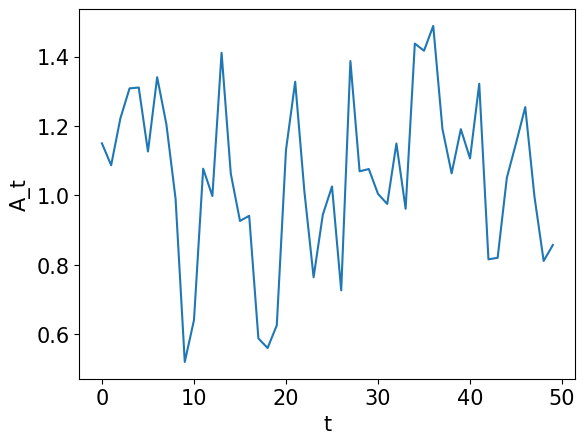

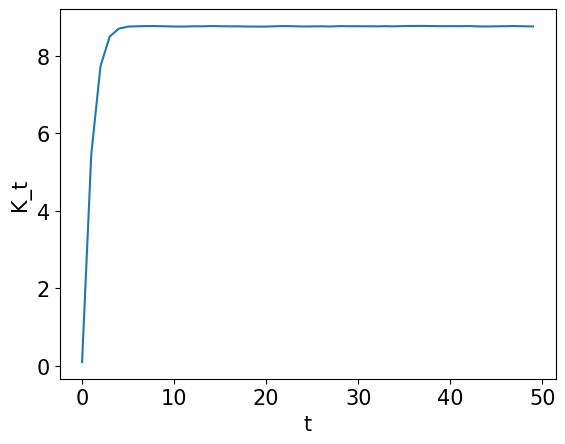

In [19]:
plt.plot(X_simulation[:, 0, 0])
plt.xlabel("t")
plt.ylabel("A_t")
plt.show()

plt.plot(X_simulation[:, 0, 1])
plt.xlabel("t")
plt.ylabel("K_t")
plt.show()

## Iterating between training an simulation

In [20]:
def get_training_data(A_lb, A_ub, k_lb, k_ub, n_data):

    A = tf.random.uniform(
    shape = [n_data, 1],
    minval=A_lb,
    maxval=A_ub,
    dtype=tf.dtypes.float32)


    K = tf.random.uniform(
    shape = [n_data, 1],
    minval=k_lb,
    maxval=k_ub,
    dtype=tf.dtypes.float32)

    X = tf.concat([A, K], axis = 1)
    return X

In [21]:
def get_training_data_simulation(X_start, nn, n_periods):
    n_tracks = X_start.shape[0]
    n_dim = X_start.shape[1]

    # we simulate the model
    X_simulation = sim_periods(X_start, nn, n_periods)

    # we read out the last state (so that we can use it as starting poit for the next simulation)
    X_end = np.float32(X_simulation[-1, :, :])

    # we reshape the data into (n_tracks * n_periods) x 2 array
    X_training = np.float32(np.reshape(X_simulation, (n_tracks * n_periods, n_dim)))

    return X_training, X_end

In [22]:
"""
Define a Sequential neural network called 'nn', with input dimension 'num_input',
'num_hidden1' relu-activated hidden nodes in first hidden layer,
'num_hidden2' relu-activated hidden nodes in second hidden layer,
and 'num_output' sigmoid activated nodes in the output layer.
"""

#=====================================================================
# let's get a new neural network
nn = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', input_shape=(num_input,)),
    keras.layers.Dense(num_hidden2, activation='relu'),
    keras.layers.Dense(num_output, activation='sigmoid'),
    BoundedOutput(0.001, K_bar)
])
#=====================================================================

n_tracks = 100#50
n_periods = 50#3
print("n_tracks = ", n_tracks)
print("n_periods = ", n_periods)

# start from a random state
X_start = get_training_data(A_lb, A_ub, k_lb, k_ub, n_tracks)
print("X_start.shape = ", X_start.shape)

print("With every simulation we get", n_tracks * n_periods, "new states")

X_training, X_end = get_training_data_simulation(X_start, nn, n_periods)
print("X_training.shape = ", X_training.shape)
print("X_end.shape = ", X_end.shape)

learning_rate = 0.0001
print("learning_rate = ", learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

print(compute_cost(X_start, nn)[0])

n_tracks =  100
n_periods =  50
X_start.shape =  (100, 2)
With every simulation we get 5000 new states
X_training.shape =  (5000, 2)
X_end.shape =  (100, 2)
learning_rate =  0.0001
tf.Tensor(4.708517, shape=(), dtype=float32)


n_tracks =  100
n_periods =  50
#=================================================================
episode = 0, loss [log10] = -1.9828592538833618


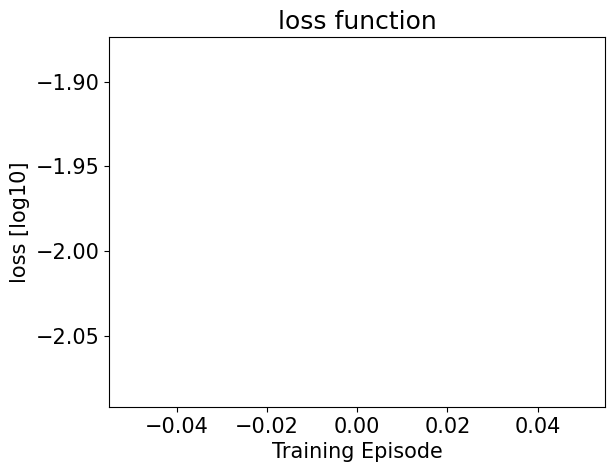

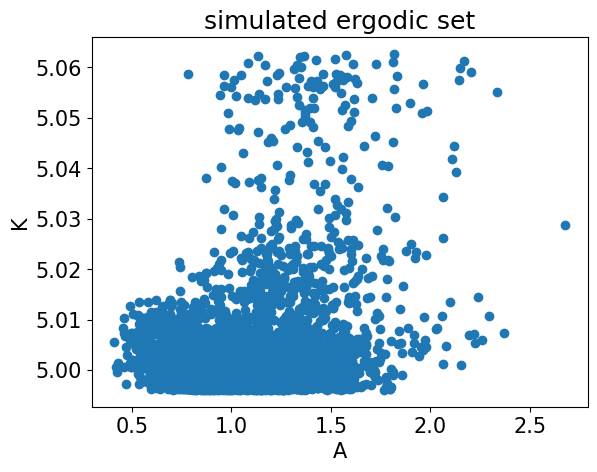

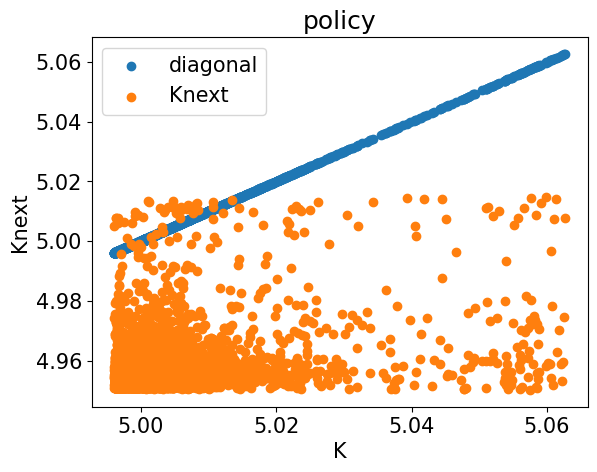

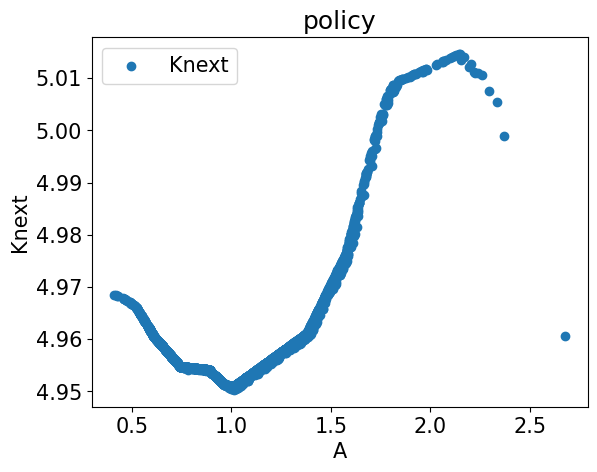

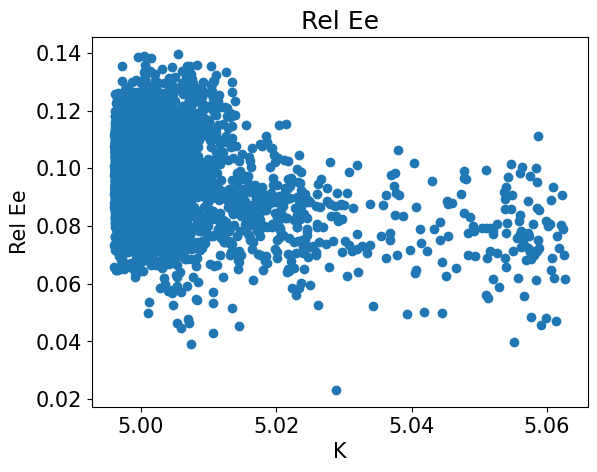

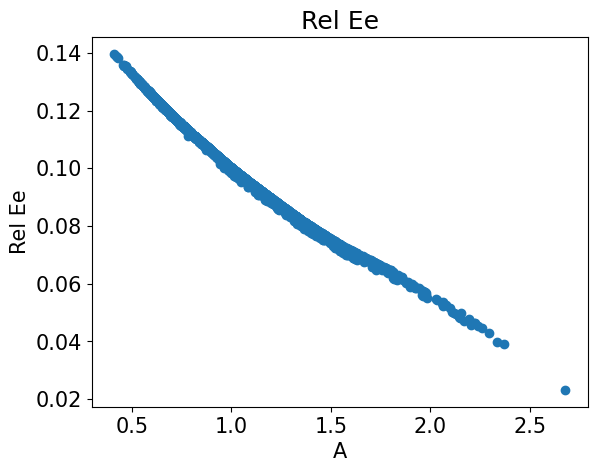

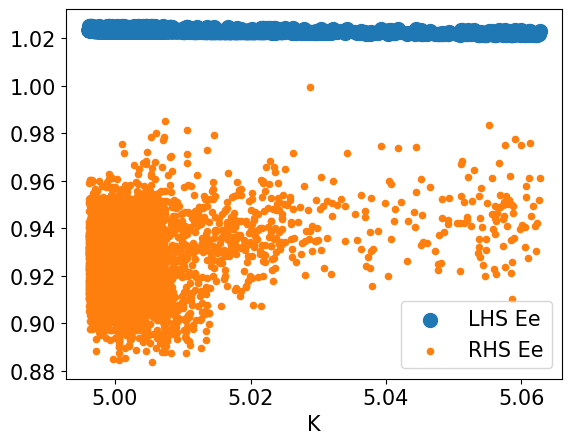

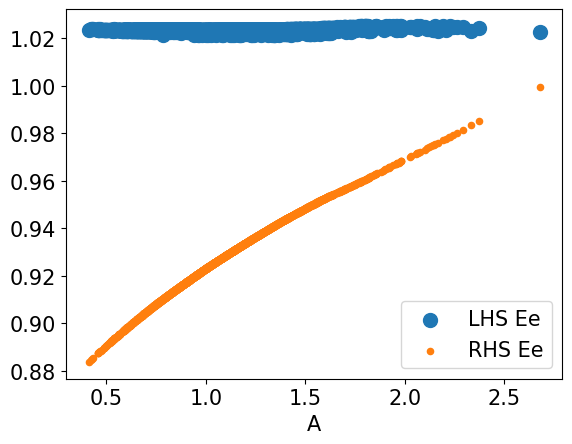

#=================================================================
episode = 1000, loss [log10] = -2.9153366088867188
#=================================================================
episode = 2000, loss [log10] = -4.900769233703613
#=================================================================
episode = 3000, loss [log10] = -5.049503326416016
#=================================================================
episode = 4000, loss [log10] = -5.061366081237793


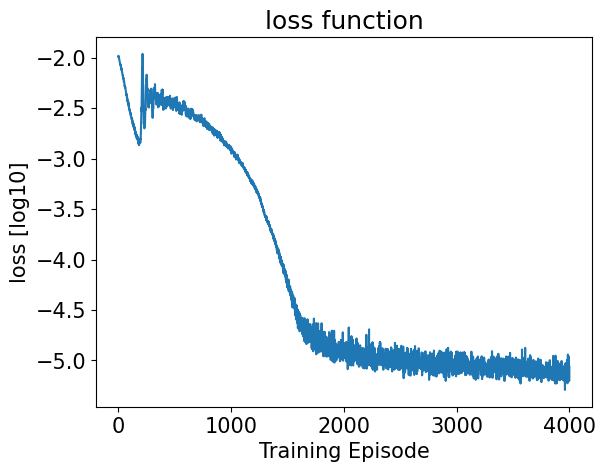

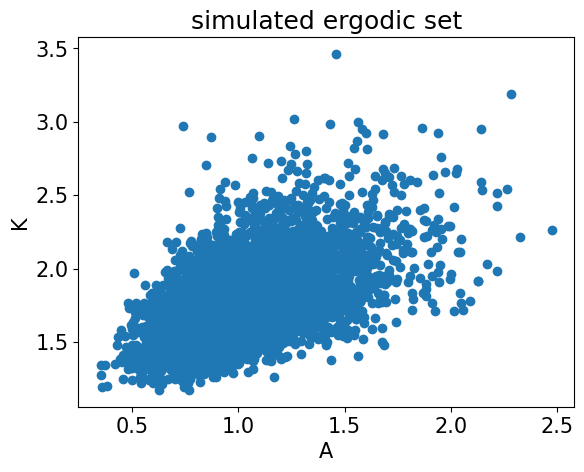

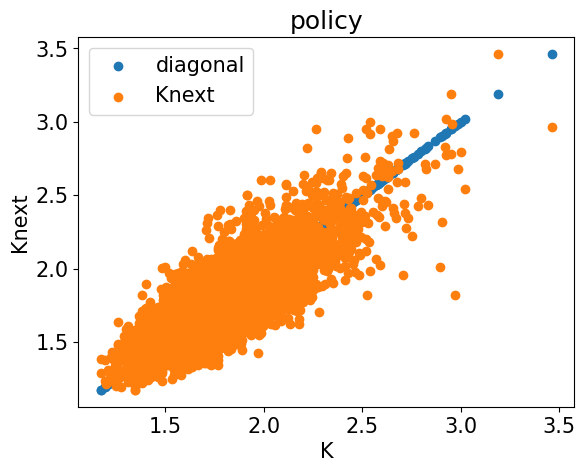

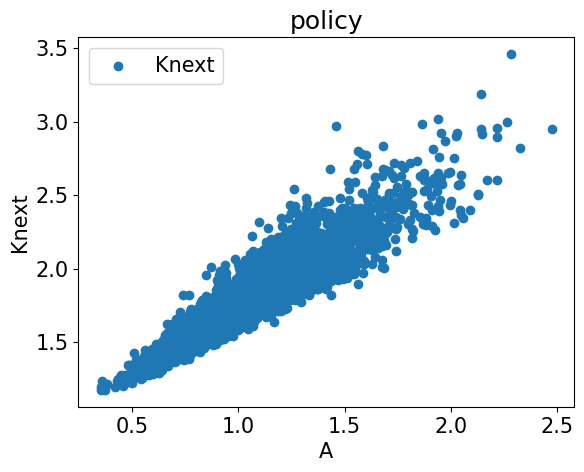

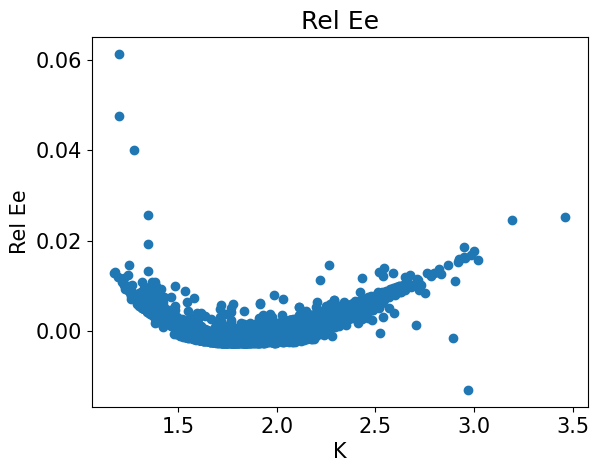

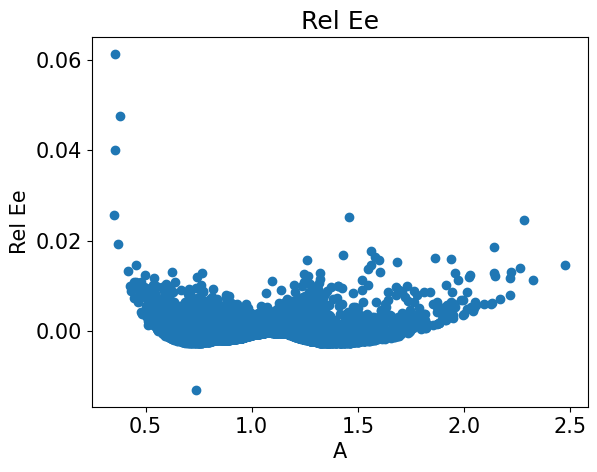

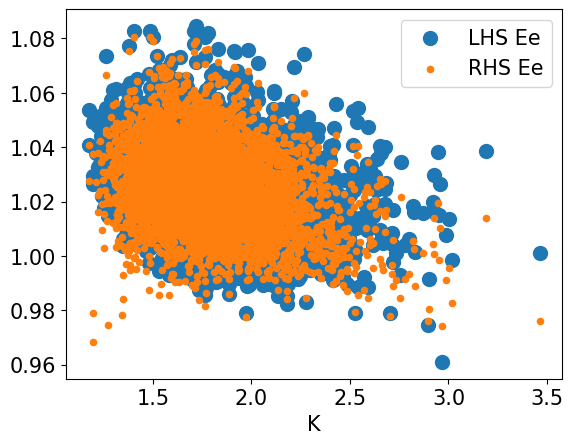

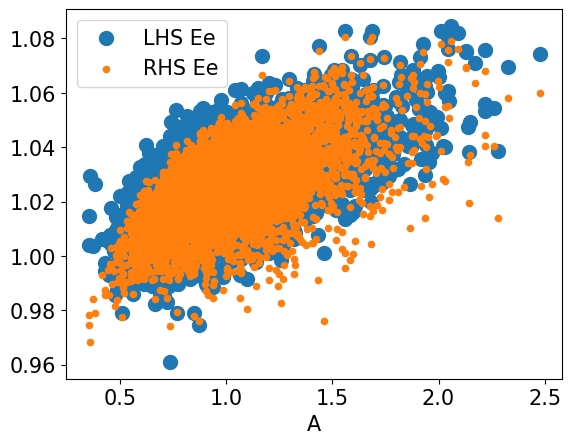

#=================================================================
episode = 5000, loss [log10] = -5.263548851013184
#=================================================================
episode = 6000, loss [log10] = -5.446151256561279
#=================================================================
episode = 7000, loss [log10] = -5.628460884094238
#=================================================================
episode = 8000, loss [log10] = -5.929695129394531


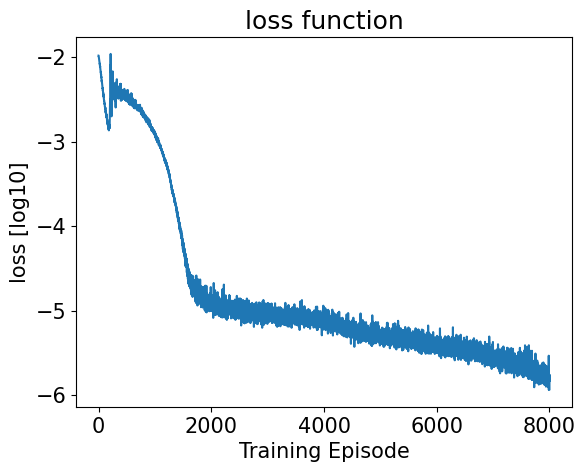

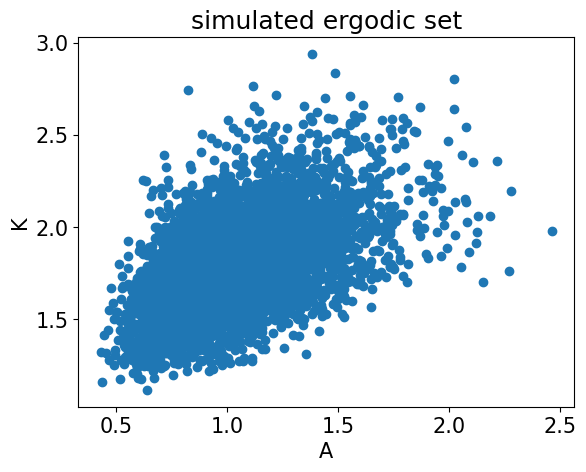

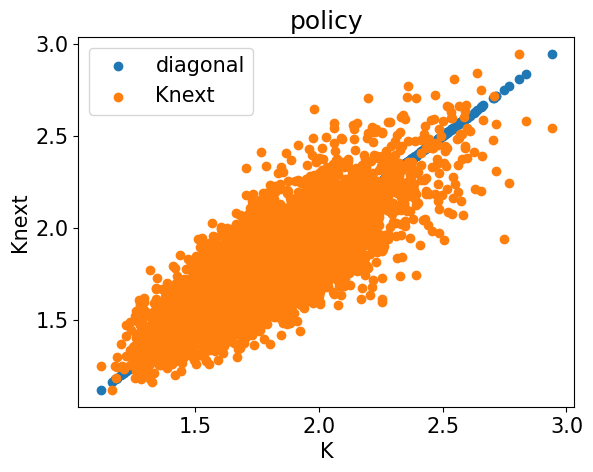

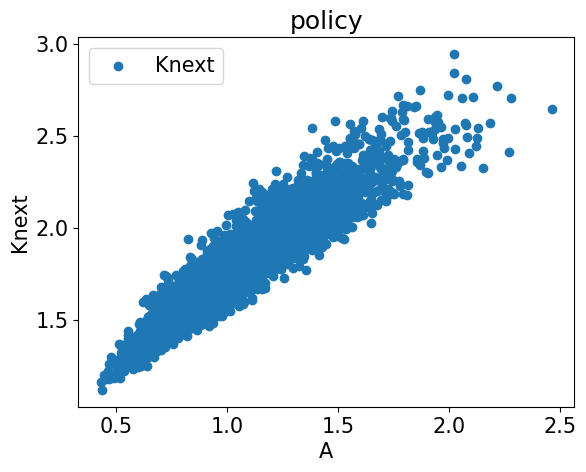

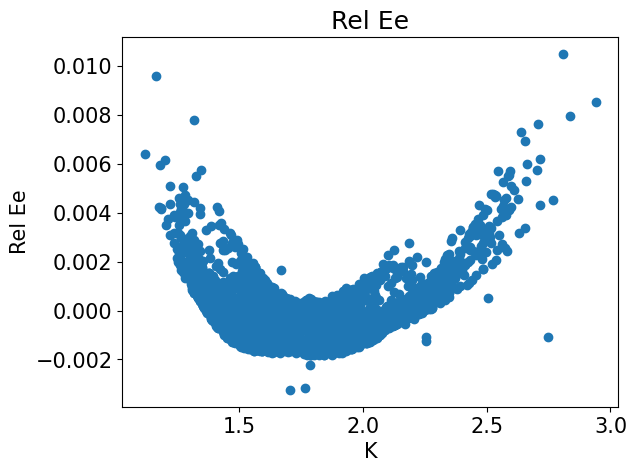

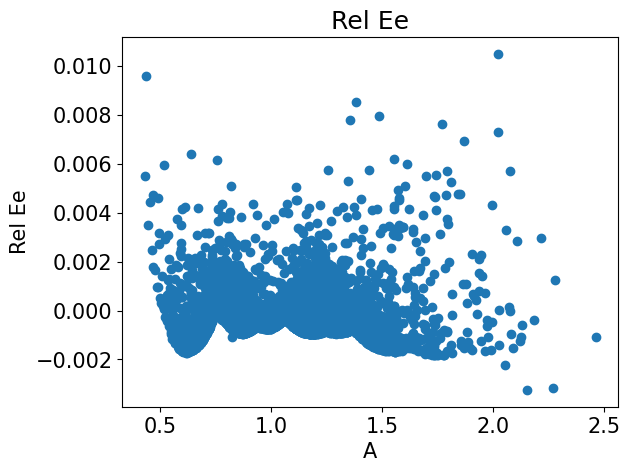

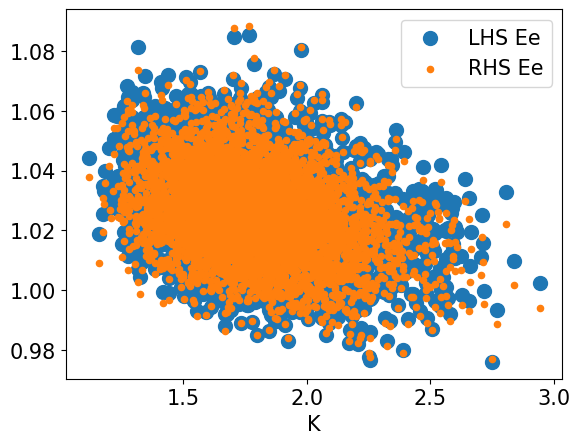

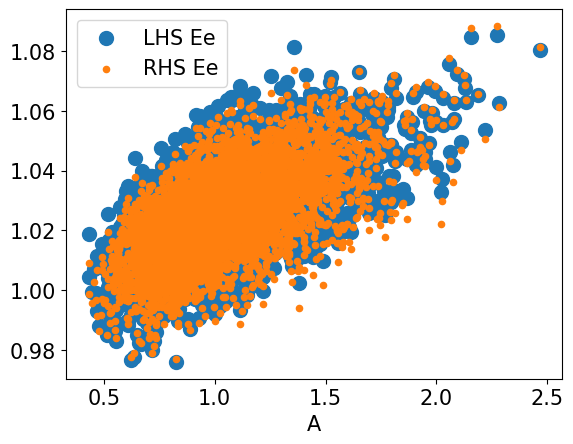

#=================================================================
episode = 9000, loss [log10] = -6.089967727661133
#=================================================================
episode = 10000, loss [log10] = -6.167724132537842
#=================================================================
episode = 11000, loss [log10] = -6.342929840087891
#=================================================================
episode = 12000, loss [log10] = -6.406009674072266


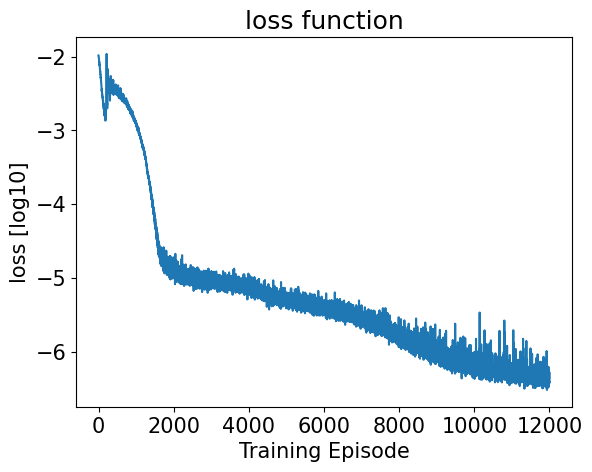

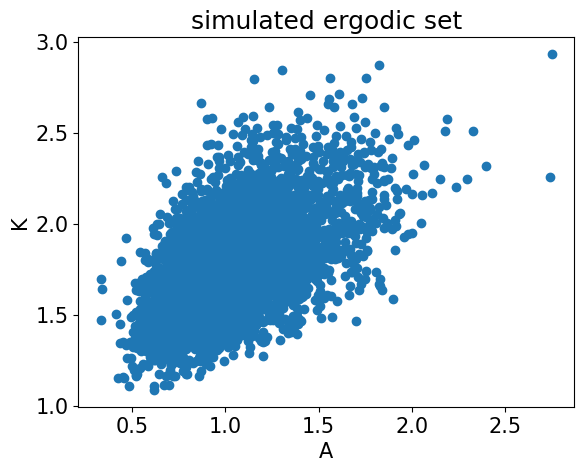

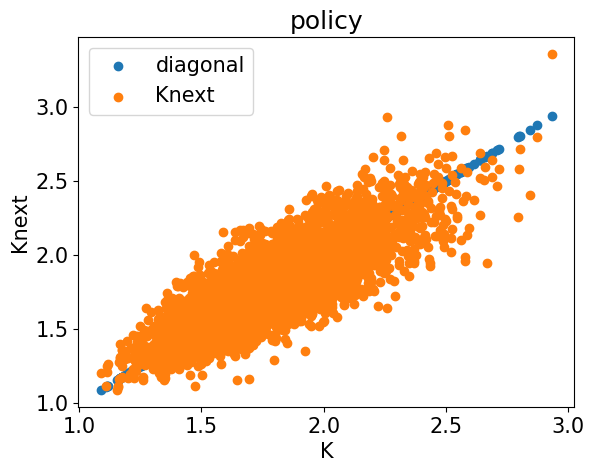

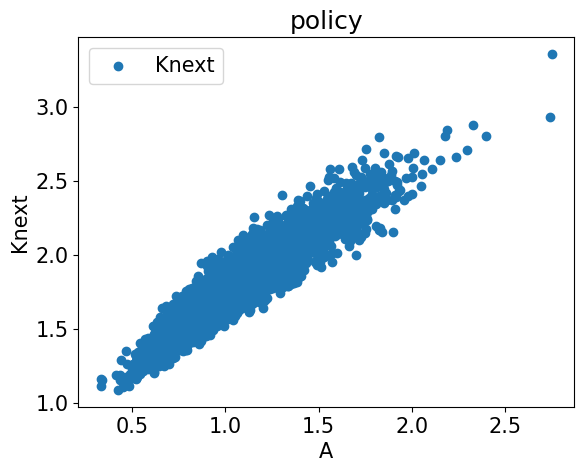

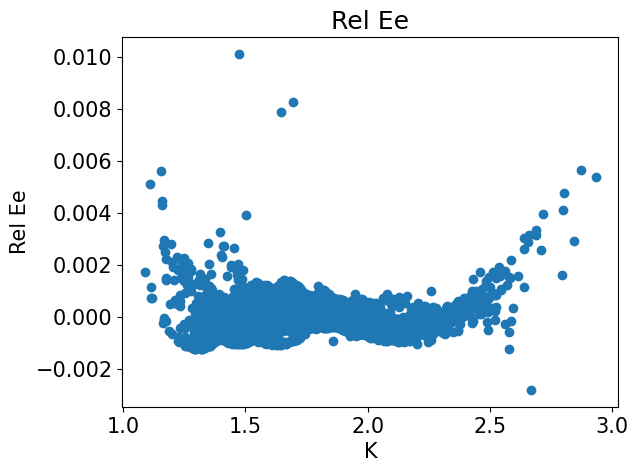

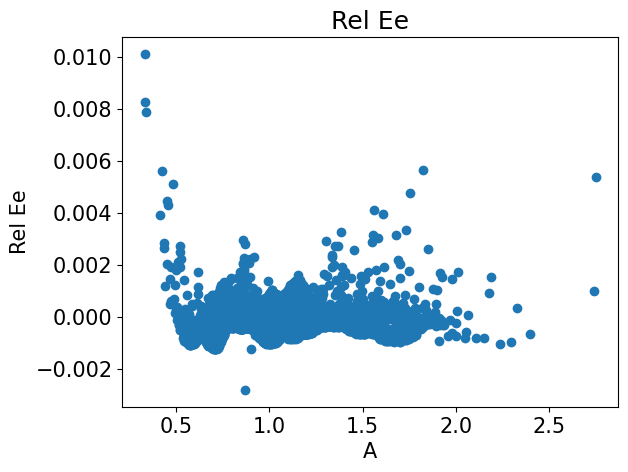

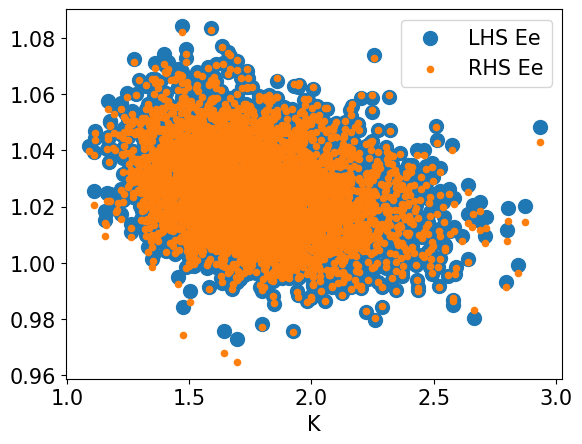

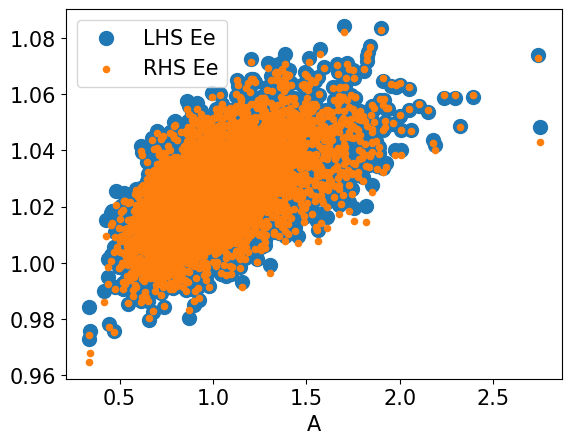

#=================================================================
episode = 13000, loss [log10] = -6.479949951171875
#=================================================================
episode = 14000, loss [log10] = -6.6551995277404785
#=================================================================
episode = 15000, loss [log10] = -6.6327009201049805
#=================================================================
episode = 16000, loss [log10] = -6.673051834106445


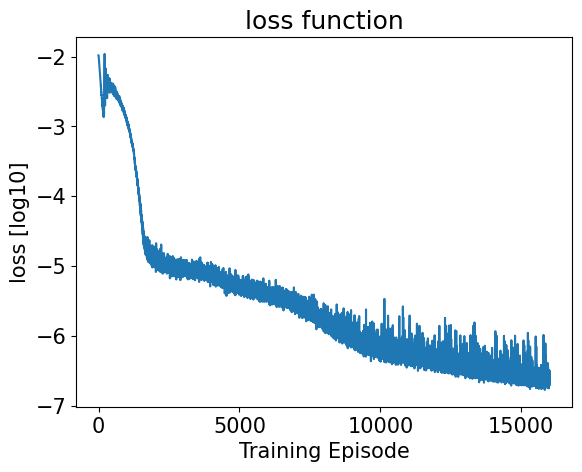

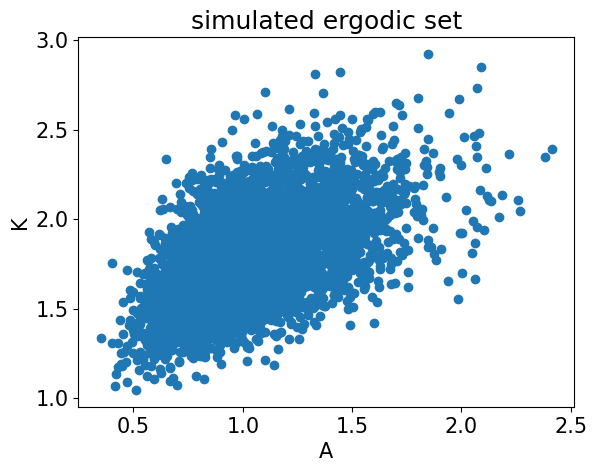

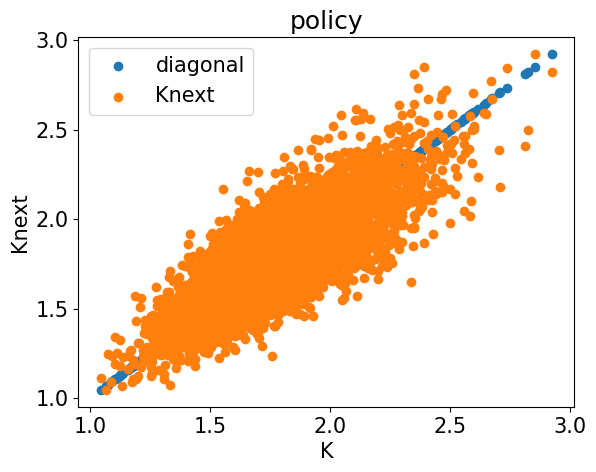

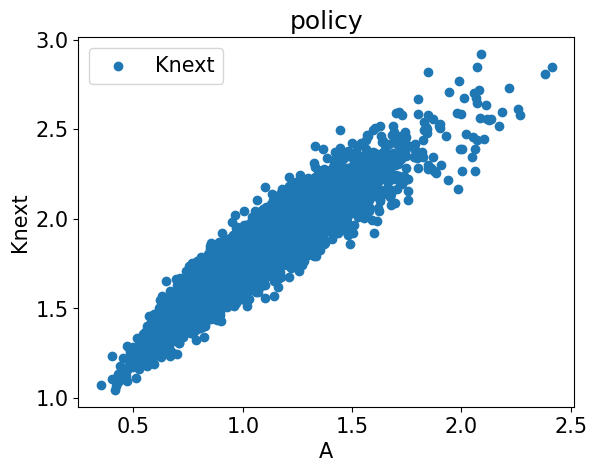

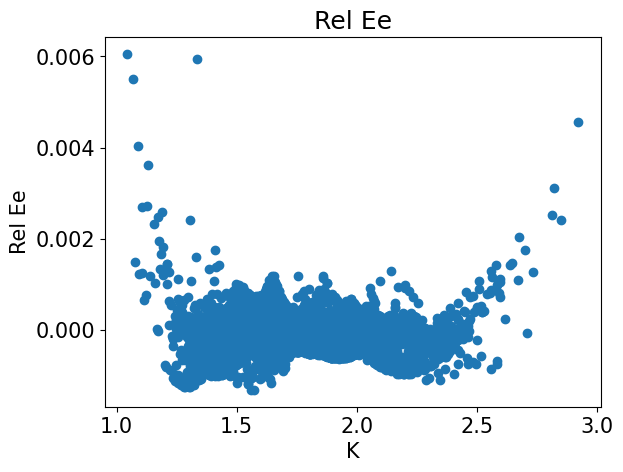

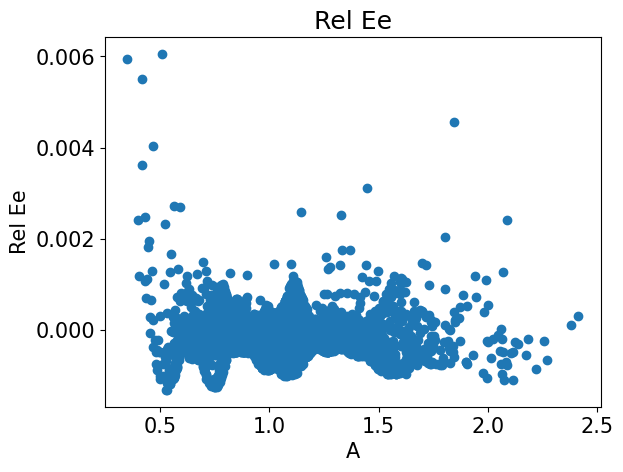

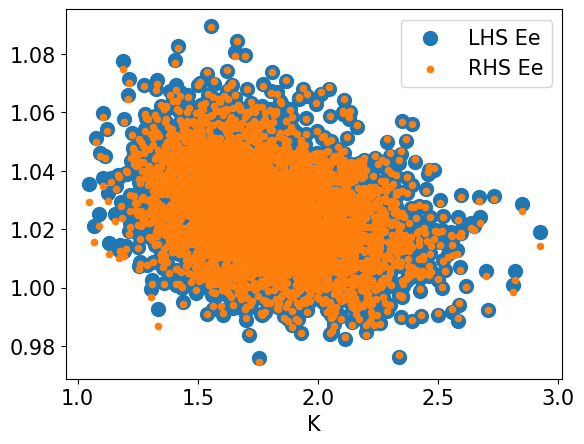

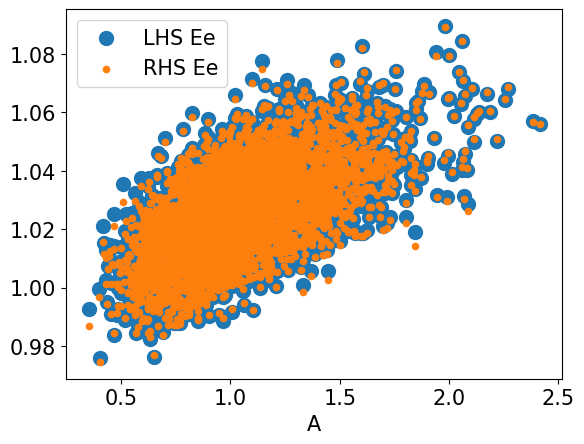

#=================================================================
episode = 17000, loss [log10] = -6.728325843811035
#=================================================================
episode = 18000, loss [log10] = -6.756500720977783
#=================================================================
episode = 19000, loss [log10] = -6.73148250579834
#=================================================================
episode = 20000, loss [log10] = -6.590915203094482


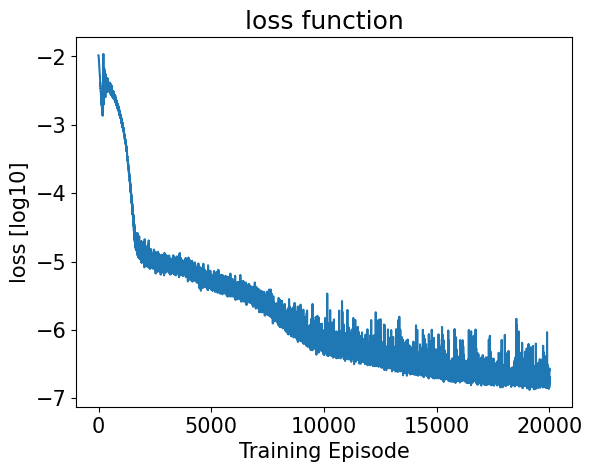

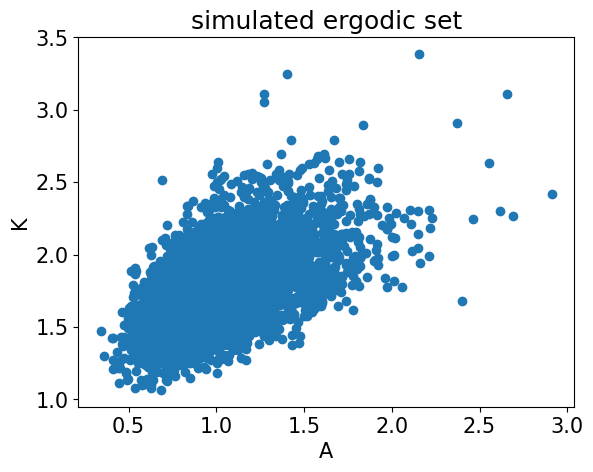

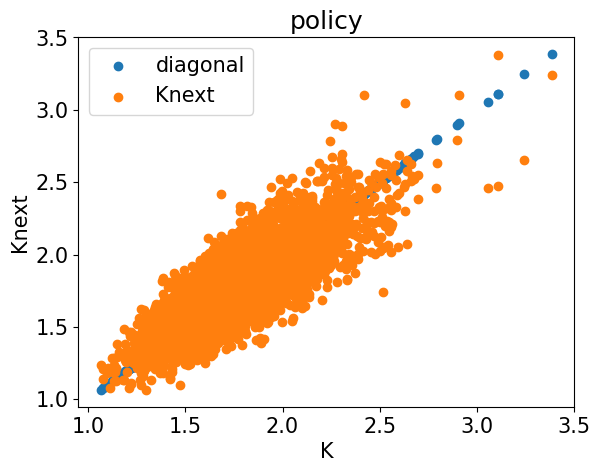

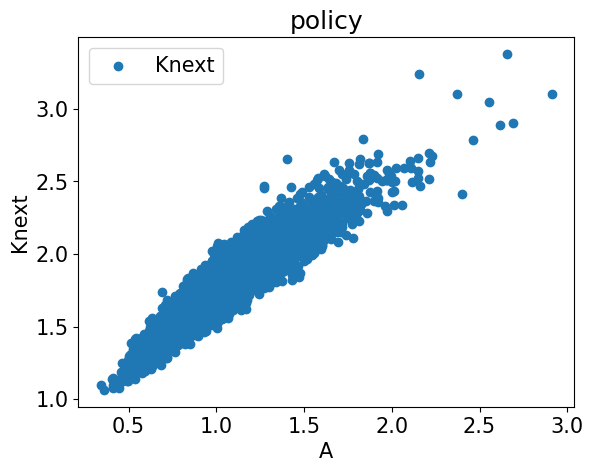

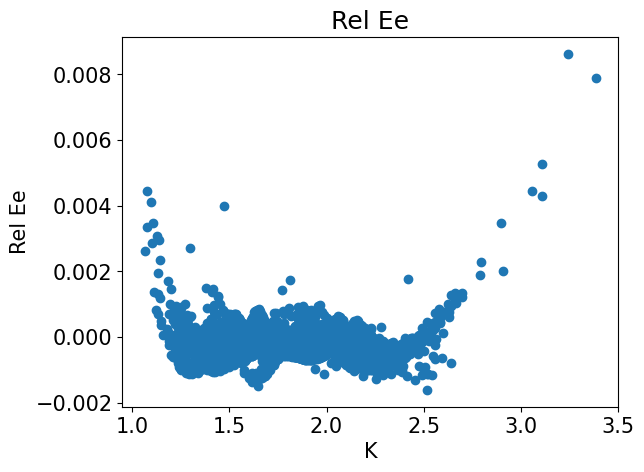

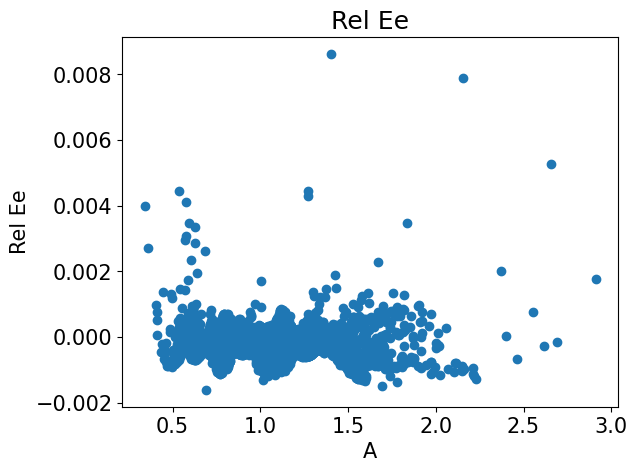

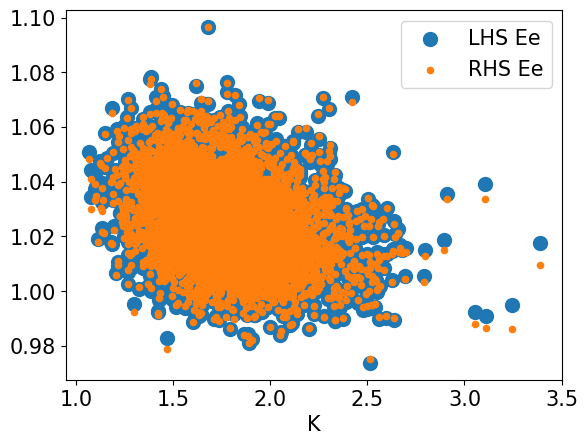

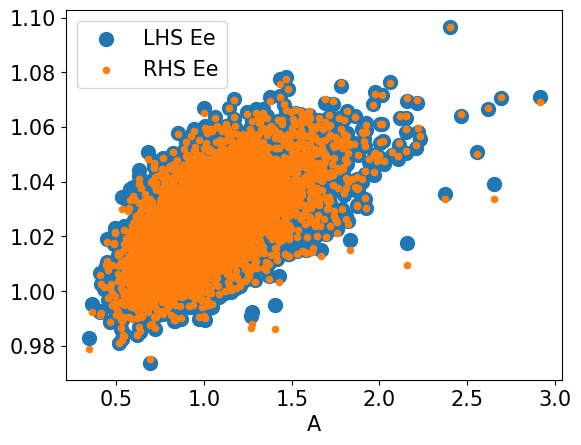

In [23]:
# Keep results for plotting
train_loss = []

num_episodes = 20_001

# initialize X_start
X_start = X_end
print("n_tracks = ", X_start.shape[0])
print("n_periods = ", n_periods)

for ep in range(num_episodes):
    # generate training data, now by sampling
    X, X_end = get_training_data_simulation(X_start, nn, n_periods)

    # update X_start
    X_start = X_end

    # compute loss and gradients
    loss, grads = grad(X, nn)


    # apply gradients
    optimizer.apply_gradients(zip(grads, nn.trainable_variables))

    # record loss
    train_loss.append(loss.numpy())

    # print progress
    if ep % int(0.05 * num_episodes) == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.numpy())))

    if ep % int(0.2 * num_episodes) == 0 or ep == num_episodes - 1:
        cost, errREE, K_tplus1, LHS, RHS = compute_cost(X, nn)

        plt.title("loss function")
        plt.plot(np.log10(np.array(train_loss)))
        plt.xlabel("Training Episode")
        plt.ylabel("loss [log10]")
        plt.show()
        plt.close()

        plt.title("simulated ergodic set")
        plt.scatter(X[:, 0], X[:, 1])
        plt.xlabel("A")
        plt.ylabel("K")
        plt.show()
        plt.close()


        plt.title("policy")
        plt.xlabel("K")
        plt.ylabel("Knext")
        plt.scatter(X[:, 1], X[:, 1], label = "diagonal")
        plt.scatter(X[:, 1], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("policy")
        plt.xlabel("A")
        plt.ylabel("Knext")
        plt.scatter(X[:, 0], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("K")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 1], errREE[:, 0], label="REE")
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("A")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 0], errREE[:, 0], label="REE")
        plt.show()
        plt.close()

        plt.xlabel("K")
        plt.scatter(X[:, 1], LHS[:, 0], s = 100, label="LHS Ee")
        plt.scatter(X[:, 1], RHS[:, 0], s = 20, label="RHS Ee")
        plt.legend()
        plt.show()
        plt.close()

        plt.xlabel("A")
        plt.scatter(X[:, 0], LHS[:, 0], s = 100, label="LHS Ee")
        plt.scatter(X[:, 0], RHS[:, 0], s = 20, label="RHS Ee")
        plt.legend()
        plt.show()
        plt.close()

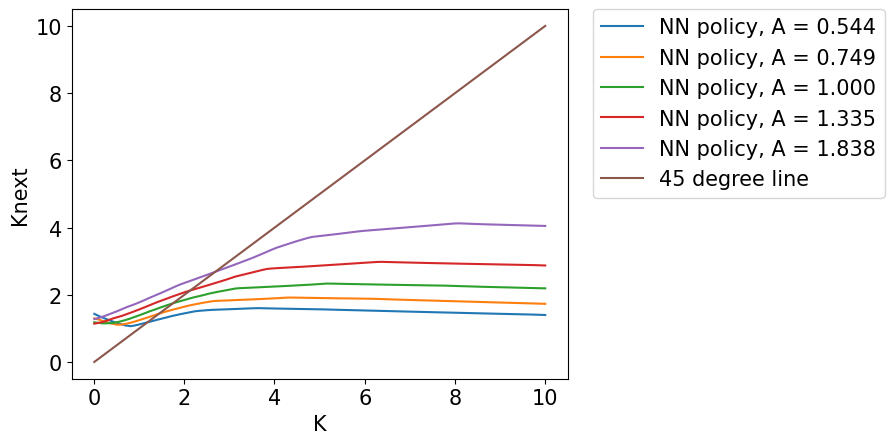

In [24]:
# Create X that is a linear grip of K with A fixed at 1.0
n_k_points = 100
K_grid = np.linspace(0.01, 10, n_k_points, dtype = np.float32)

# Now plot the policy functions
A_values =  np.exp(x_int_norm * sigma_tfp)
for i, A in enumerate(A_values):
    A_fixed = A * np.ones(n_k_points, dtype = np.float32)
    X_grid = np.column_stack((A_fixed, K_grid))
    Knext_pred = nn(X_grid).numpy()
    plt.plot(K_grid, Knext_pred, label = "NN policy, A = {:.3f}".format(A))
plt.plot(K_grid, K_grid, label = "45 degree line")
plt.xlabel("K")
plt.ylabel("Knext")
plt.legend()
# put legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)
plt.show()